In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# (LARGE) Mutlihead Attentive Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 128
batch_size = 32
num_points = 128
num_samples = 100000
n_epochs = 30


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(3, num_points-50))


def get_model(x_dim, y_dim):
    return AttentiveNeuralProcess(x_dim, y_dim,
                                  XEncoder=MLP,
                                 attention="multihead",
                                 XYEncoder=_DeepMLP,
                                 Decoder=_DeepMLP,
                                 r_dim=r_dim,
                                 LatentEncoder=MLP,
                                 get_cntxt_trgt=get_cntxt_trgt)


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))

/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


##  Data

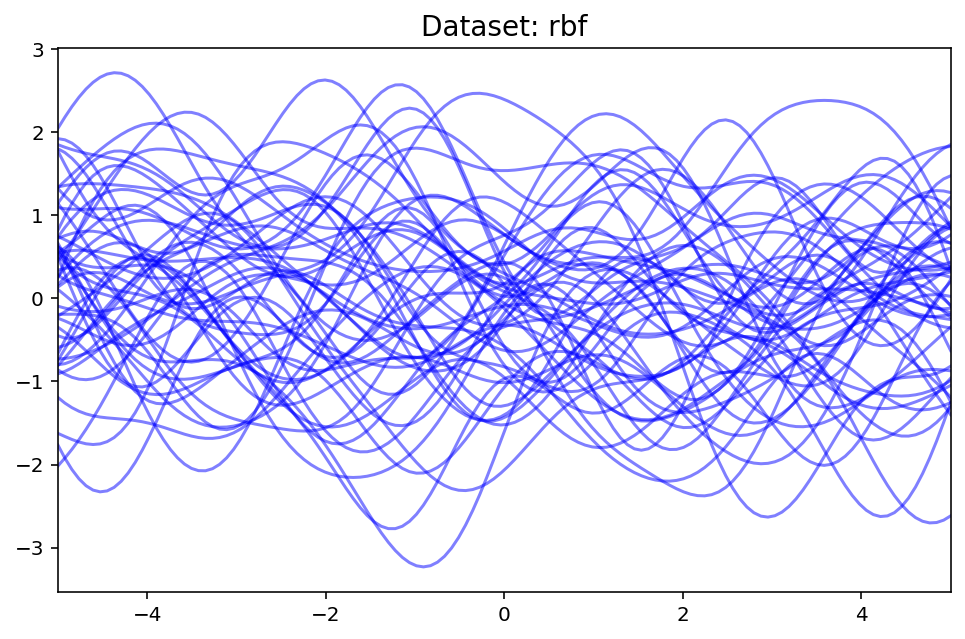

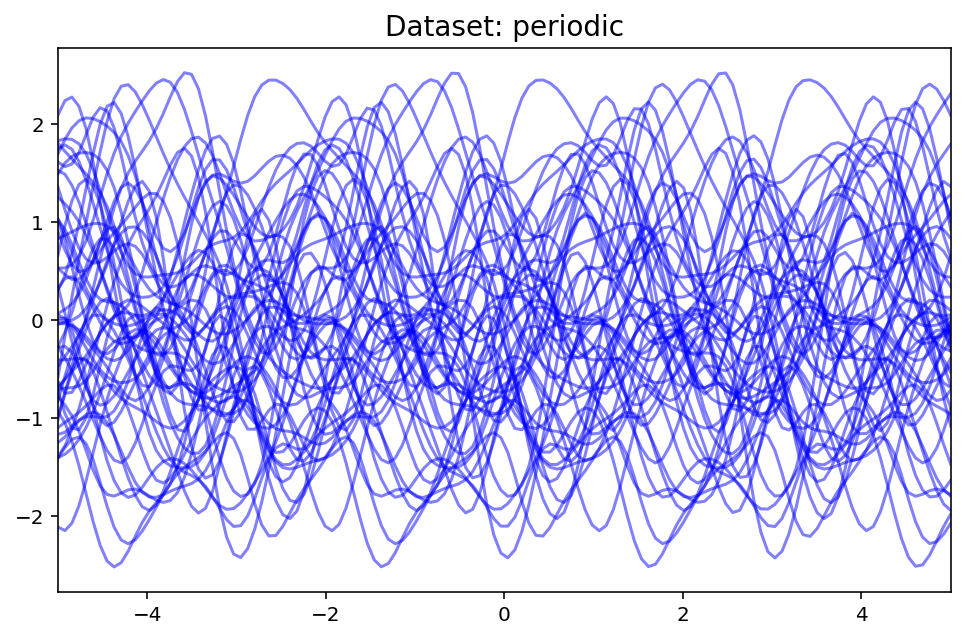

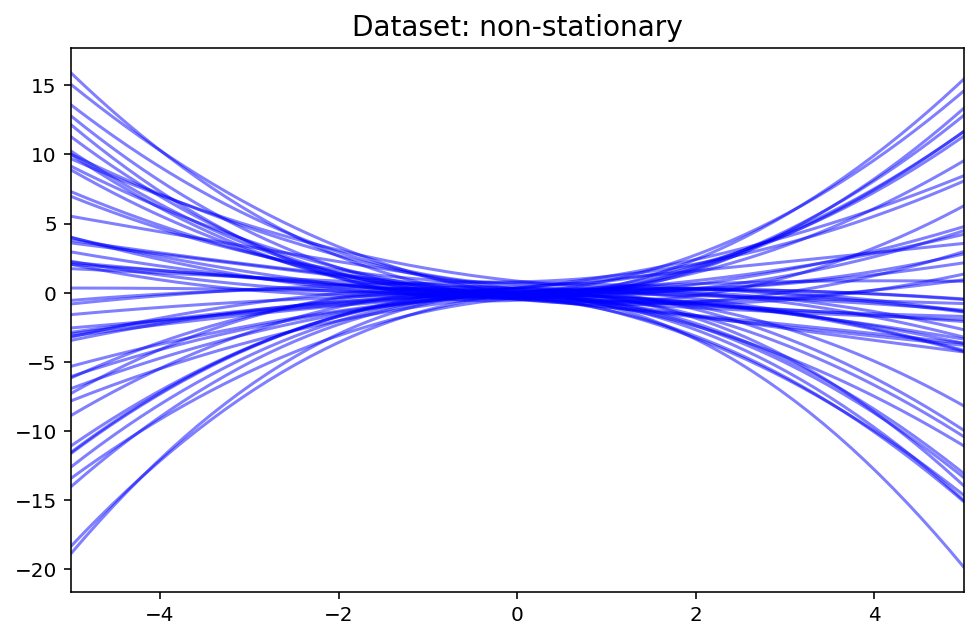

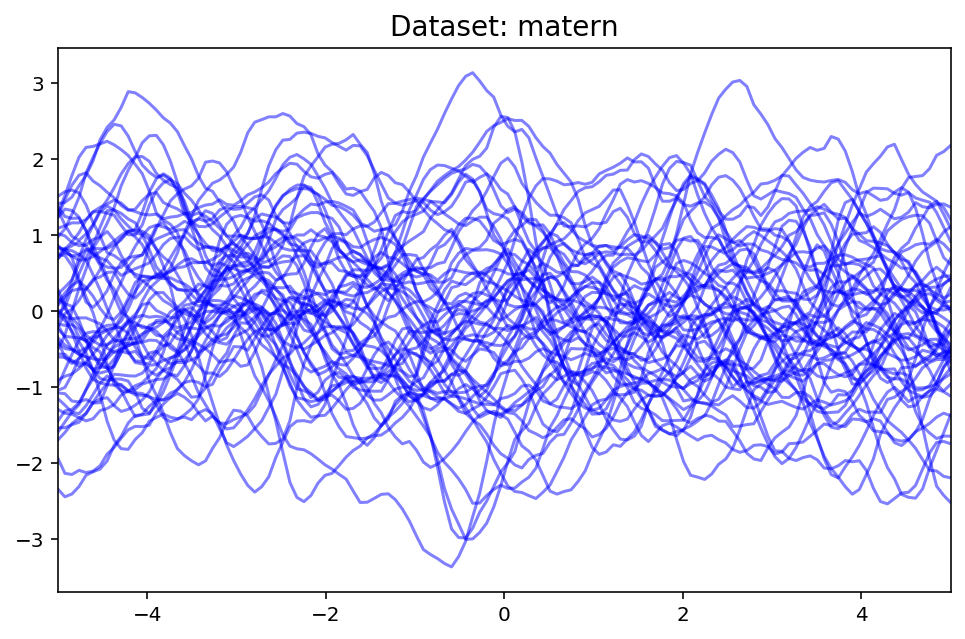

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

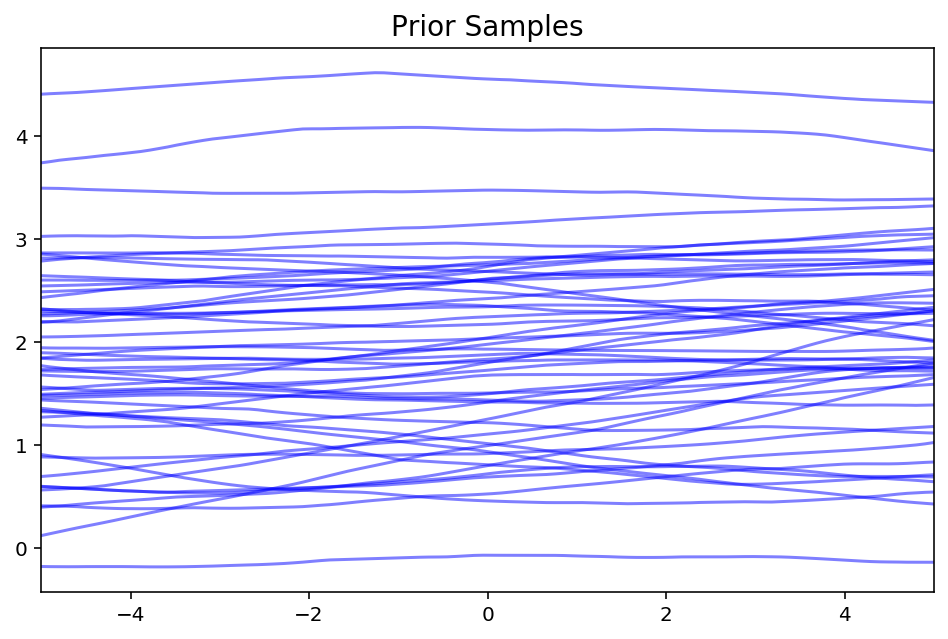

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                train_split=None,
                                lr=1e-4)  # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss      dur
-------  ------------  -------
      1      568.1017  57.4704


      2      160.3702  55.1190


      3      115.7064  57.8188


      4       88.4128  57.5086


      5       72.0934  49.4253


      6       55.9885  57.5422


      7       41.1006  46.6699


      8       24.3937  51.2055


      9        7.9464  57.0141


     10       -7.5850  48.9380


     11      -22.4169  53.8797


     12      -36.9844  57.7107


     13      -51.6250  53.7849


     14      -56.4849  58.1606


     15      -67.3384  43.9402


     16      -71.8674  53.2889


     17      -78.0100  57.3380


     18      -84.4629  44.4056


     19      -88.7525  58.1399


     20      -93.0179  58.6530


     21      -92.3726  57.1916


     22      -96.8052  38.4142


     23      -99.6386  56.4626


     24     -100.0087  47.3454


     25     -104.8953  58.8664


     26     -105.8810  57.3957


     27     -104.1151  52.2483


     28     -108.2865  57.0377


     29     -107.3345  35.9469


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      7       72.3327  57.3950


      8       65.6973  57.7178


      9       58.8192  51.6295


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     17       17.6960  45.2015


     18       14.1057  53.4344


     19        8.9633  51.2935


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     28      -11.1064  56.9039


     29      -11.2690  45.7162


     30      -15.2525  38.5926

--- Training non-stationary ---



  epoch    train_loss      dur
-------  ------------  -------
      1      298.5286  57.5554


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      9     -107.5819  58.2637


     10     -111.4548  52.8507


     11     -117.3150  58.6486


     12     -118.0276  30.1539


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     20     -139.6851  58.1790


     21     -140.2262  58.3939


     22     -142.0794  53.2619


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     30     -149.8882  58.2313

--- Training matern ---



  epoch    train_loss      dur
-------  ------------  -------
      1      352.3608  58.8587


      2      133.6261  58.5340


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     10       50.5083  58.4435


     11       42.3567  58.3465


     12       34.0975  58.1358


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     24      -16.0074  30.3710


     25      -20.4999  30.3277


     26      -22.0836  30.3185


     27      -21.2364  30.3167


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Trained Prior 
The prior should now encode some information about the shapes of the functions.

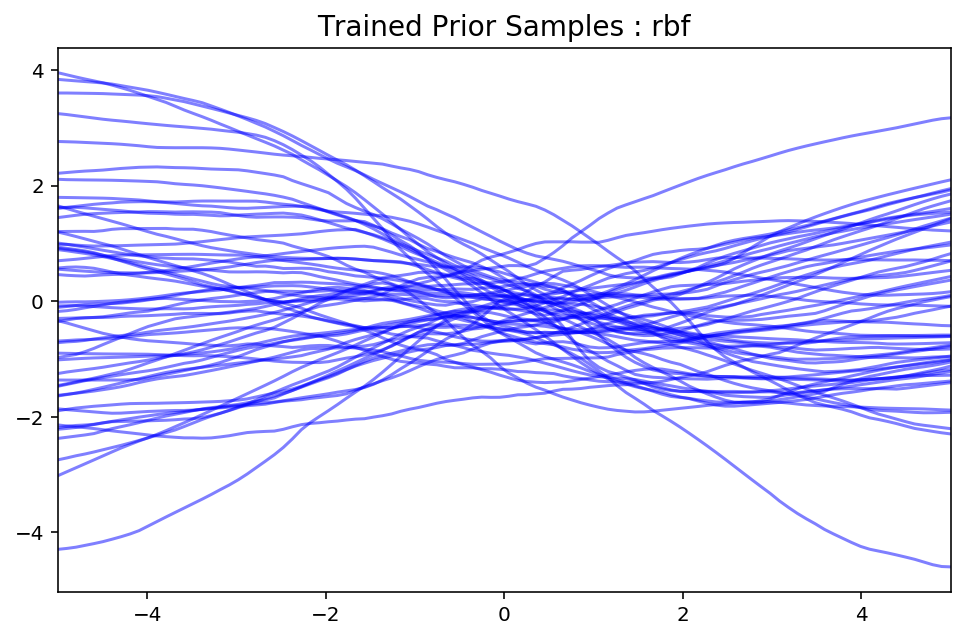

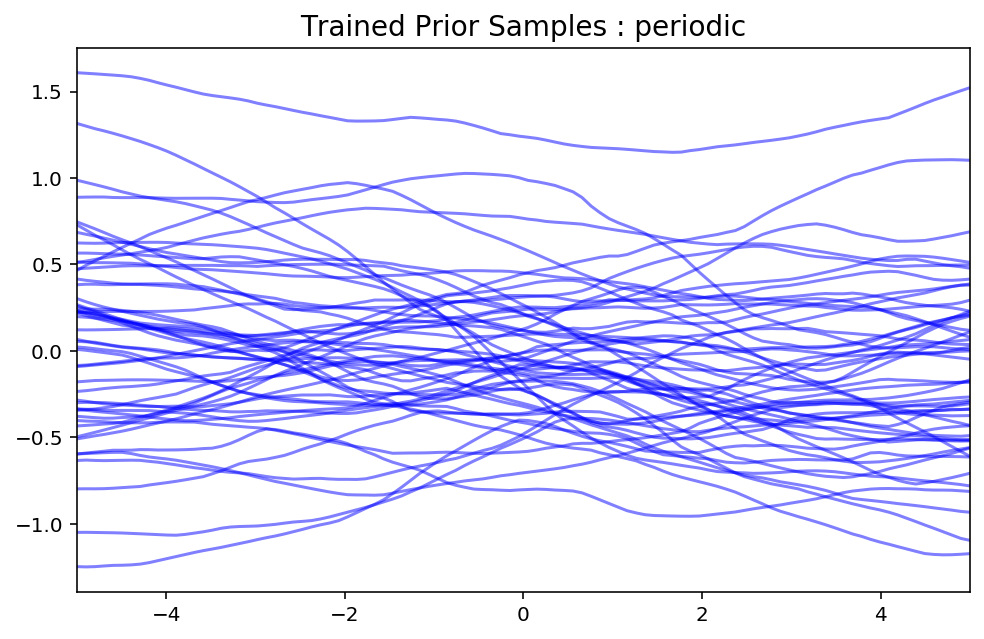

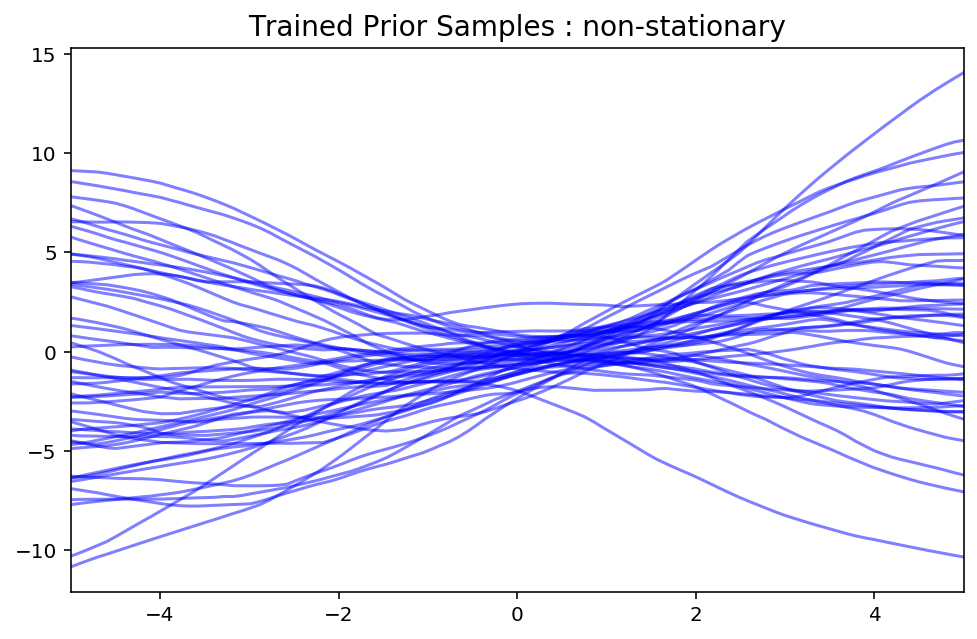

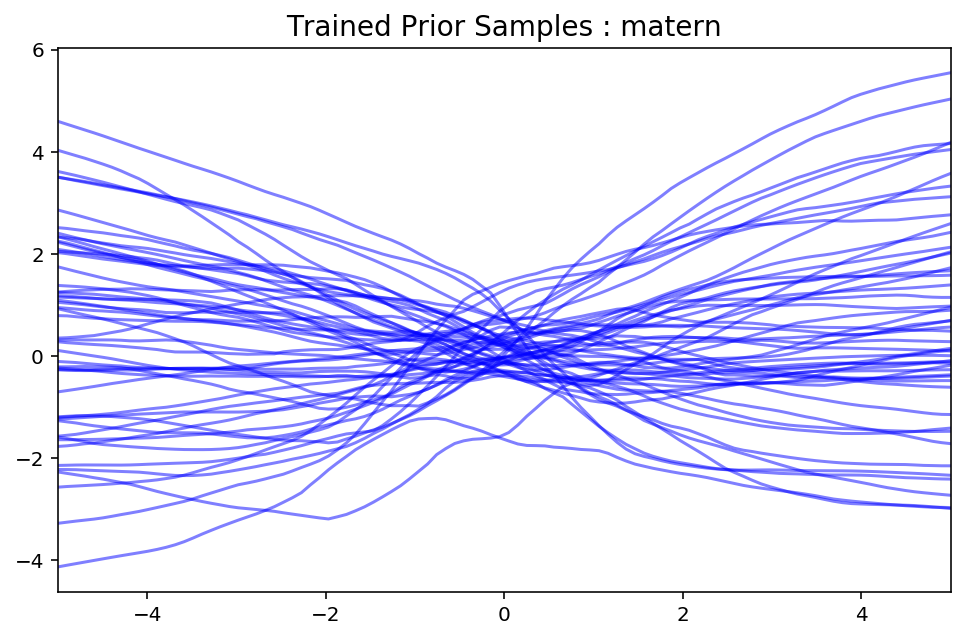

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.44254267
std: 0.38949952
std: 0.11890314
std: 0.4552634


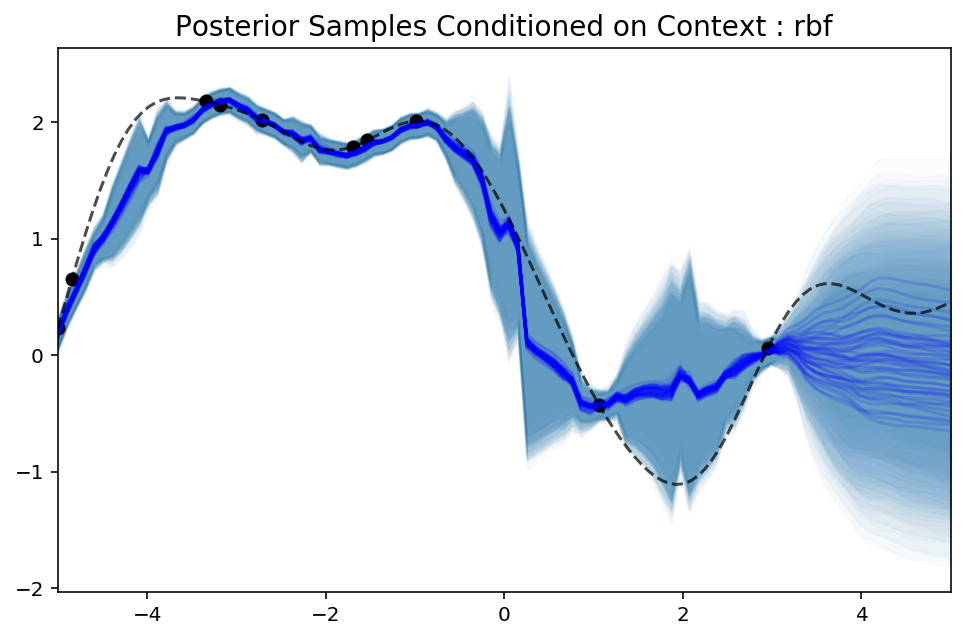

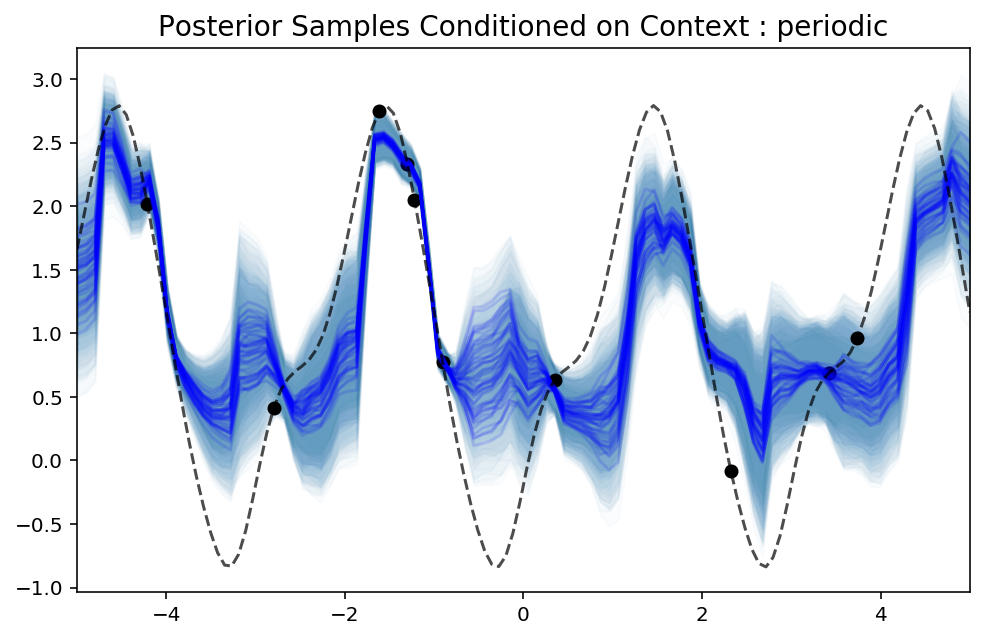

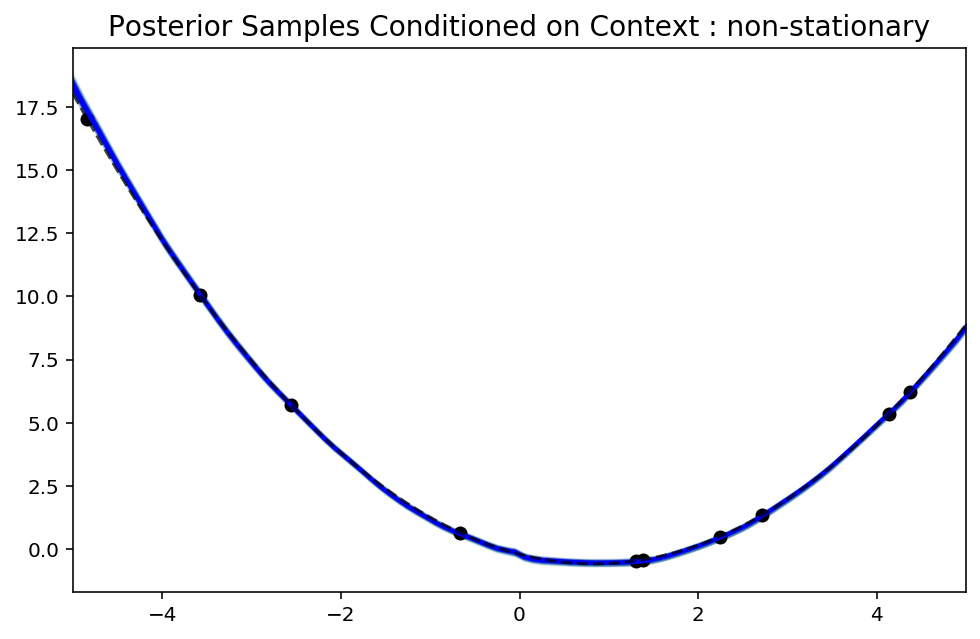

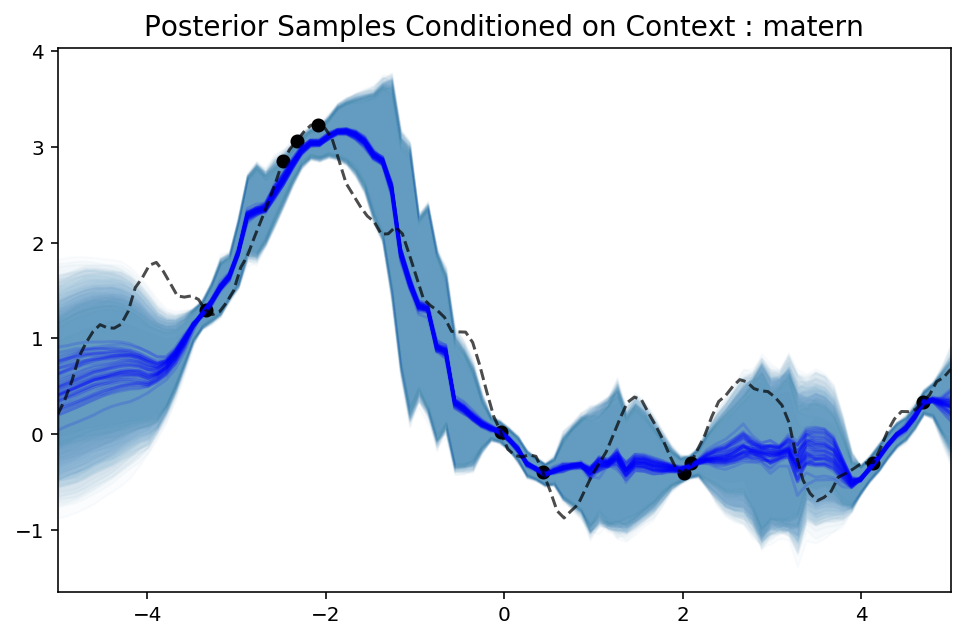

In [11]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y), is_plot_std=True,
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 0.5872055
std: 0.9813869
std: 1.1924884
std: 0.7588912


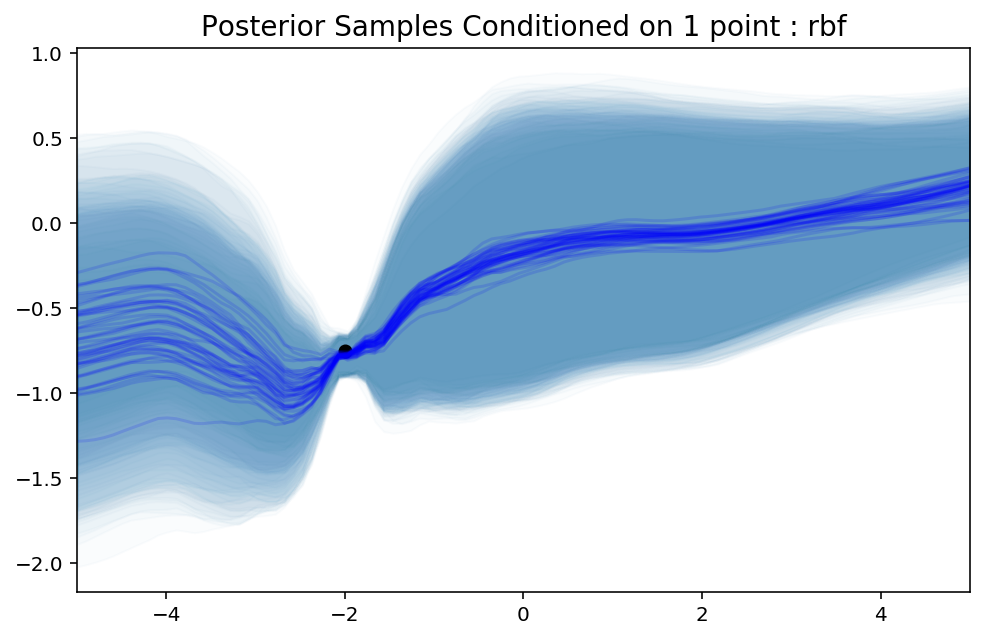

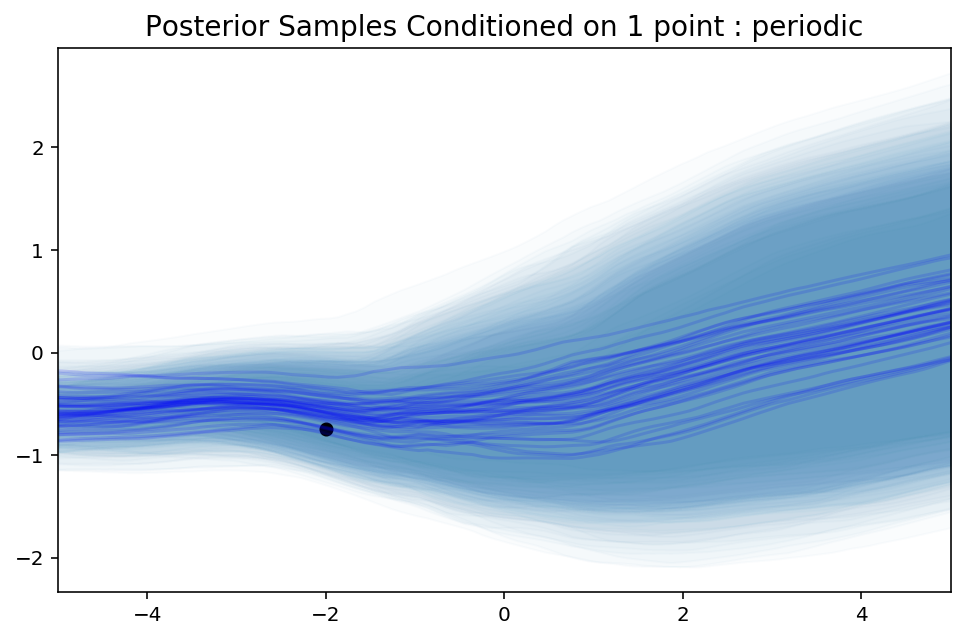

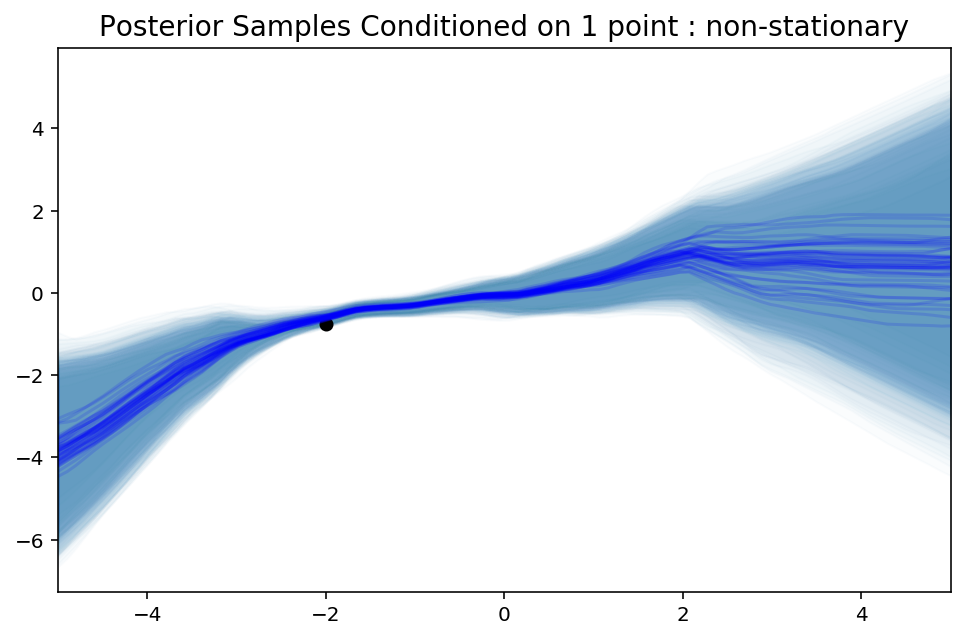

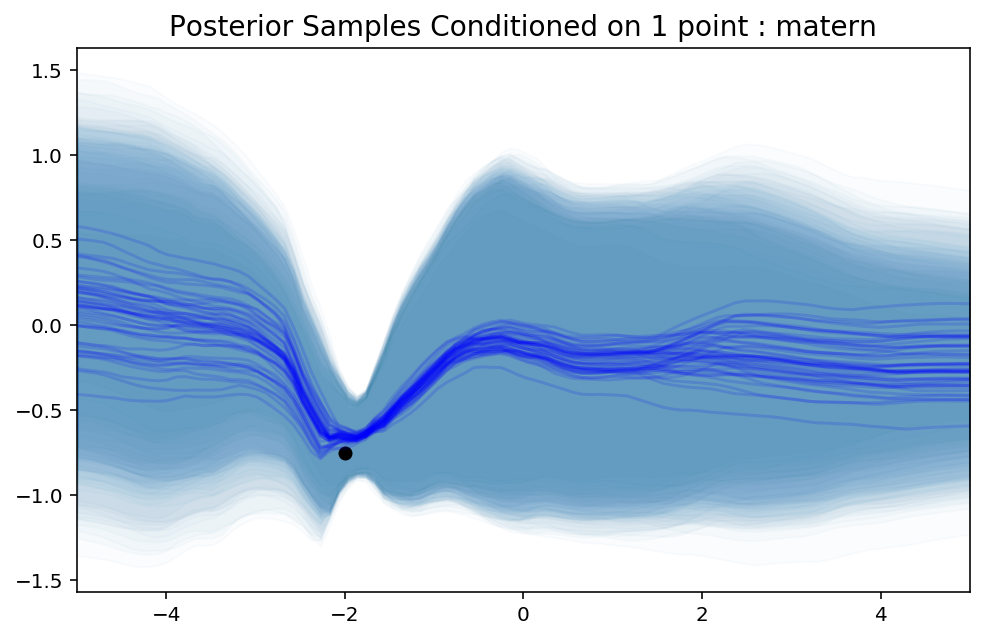

In [14]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k),
                          is_plot_std=True)

std: 0.6121632
std: 0.88608545
std: 1.2203311
std: 0.6611946


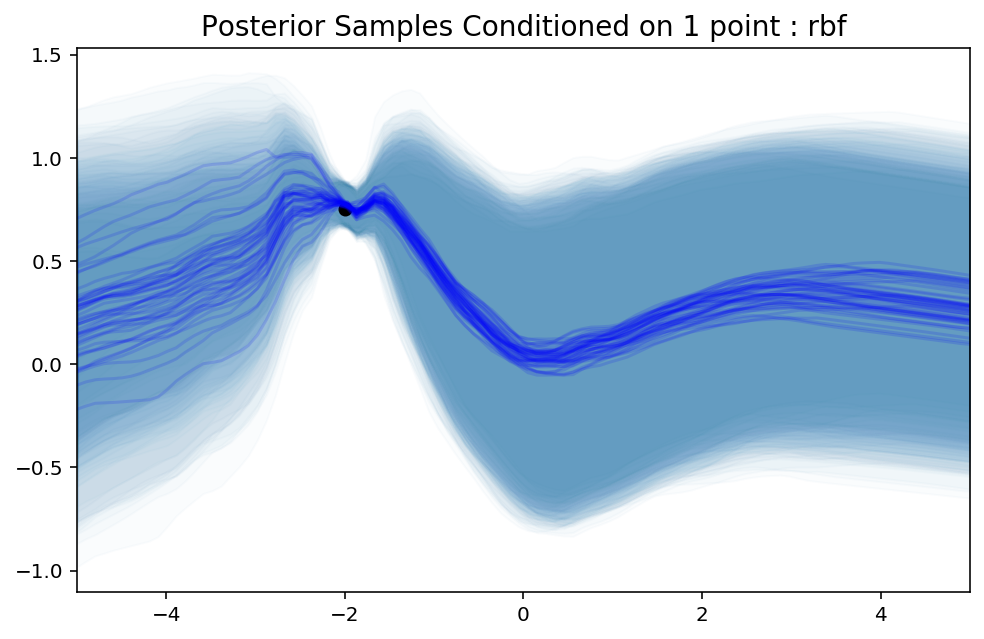

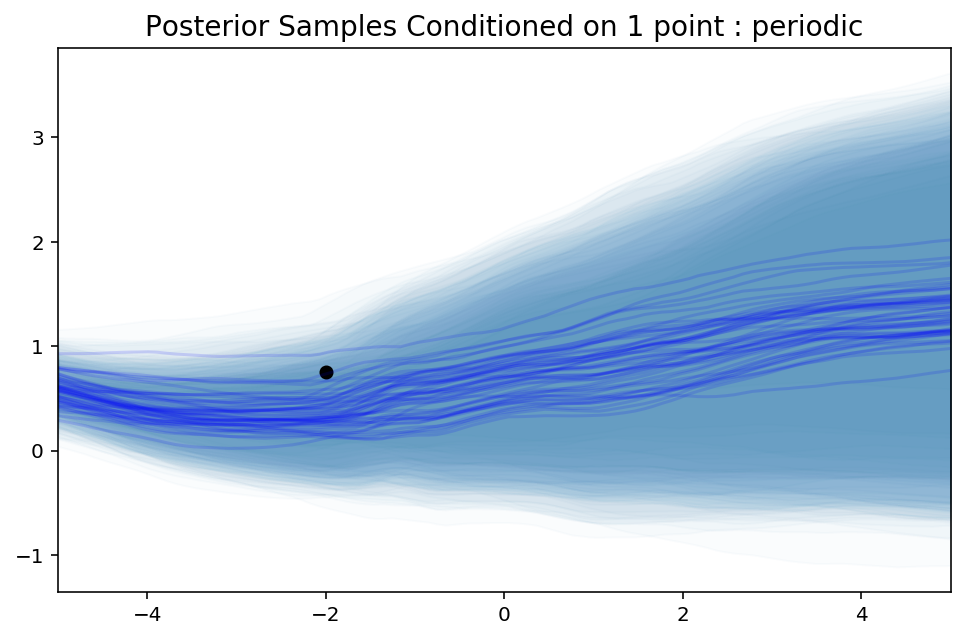

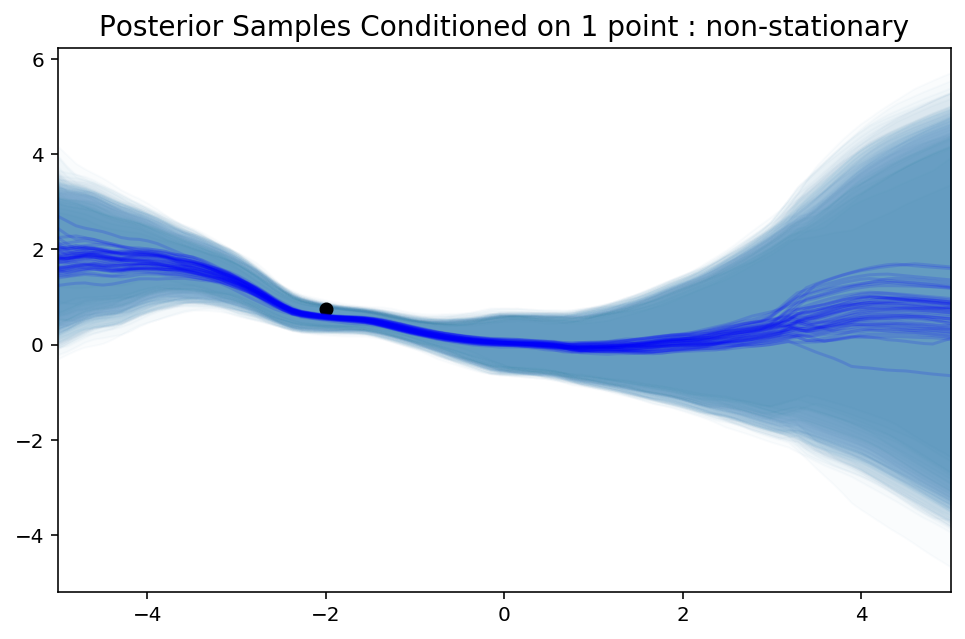

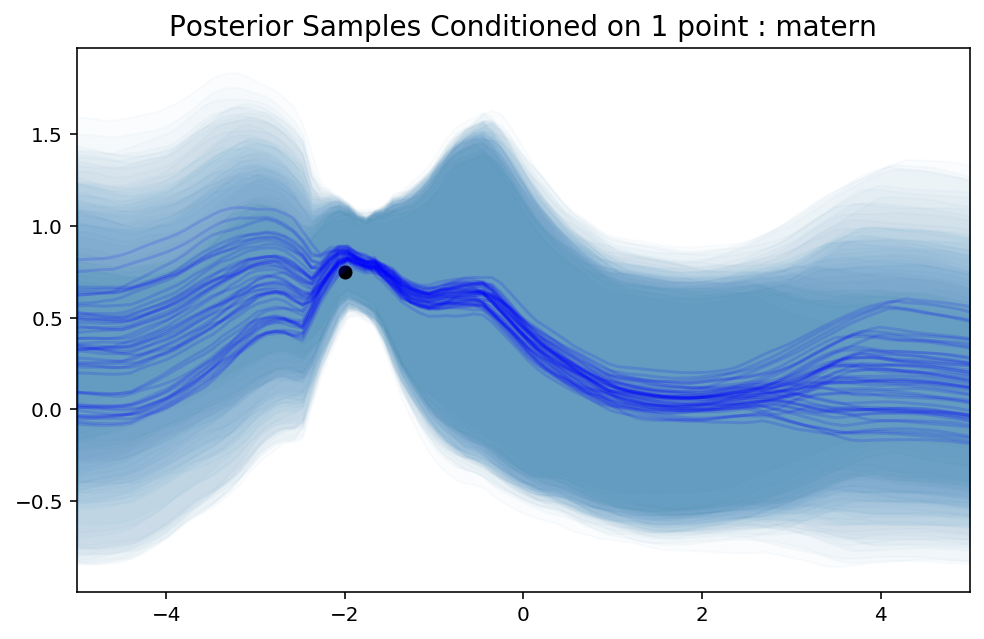

In [15]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k),
                          is_plot_std=True)